In [1]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model


In [2]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Forwarding an image through the network
In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size. To help us do this, we will create a function load_image(path) which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [4]:

import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


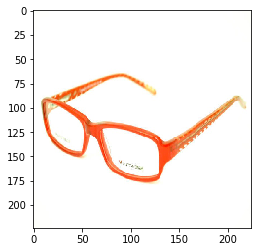

In [5]:
img, x = load_image("image1.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)


# The shape of the image is [1, 224, 224, 3]. The reason it has the extra first dimension with 1 element is that the network can take batches of images to process them all simultaneously. So for example, 10 images can be propagated through the network if x has a shape of [10, 224, 224, 3].

Let's get class predictions from this model. We forward x through model and then use the built-in decode_predictions to look up the class names.

In [25]:
# forward the image through the network
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

predicted hook with probability 0.149
predicted sunglass with probability 0.114
predicted sunglasses with probability 0.096
predicted loupe with probability 0.045
predicted hair_slide with probability 0.041


# Feature extraction
What we have in the model variable is a highly effective image classifier trained on the ImageNet database. We expect that the classifier must form a very effective representation of the image in order to be able to classify it with such high accuracy. We can use this to our advantage by re-purposing this for another task.

What we do is we copy the model, but remove the last layer (the classification layer), so that the final layer of the new network, called feat_extractor is the second 4096-neuron fully-connected layer, "fc2 (Dense)".

The way we do this is by instantiating a new model called feature_extractor which takes a reference to the desired input and output layers in our VGG16 model. Thus, feature_extractor's output is the layer just before the classification, the last 4096-neuron fully connected layer. It looks like a copy, but internally, all Keras is doing is making a pointer to each of these layers and not actually copying anything. Thus, the output "prediction" from feat_extractor will just be the layer fc2 from model.

If we run the summary() function again, we see that the architecture of feat_extractor is identical to the original model, except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [6]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Now let's see the feature extractor in action. We pass the same image from before into it, and look at the results. The predict function returns an array with one element per image (in our case, there is just one). Each element contains a 4096-element array, which is the activations of the last fully-connected layer fc2 in VGG16. Let's plot the array as well.

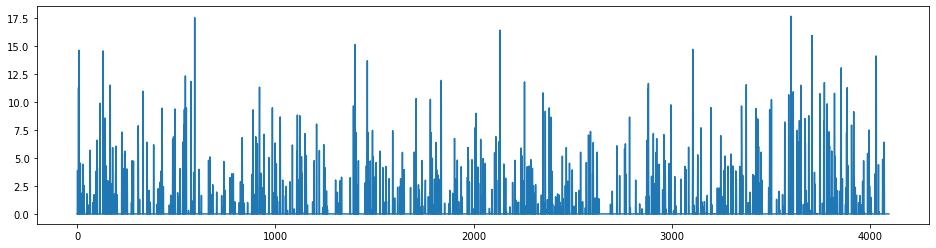

In [7]:

img, x = load_image("322868_1100-800x825.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

# Our expectation is that the fc2 activations form a very good representation of the image, such that similar images should produce similar activations. In other words, the fc2 activations of two images which have similar content should be very close to each other. We can exploit this to do information retrieval.

In the next cell, we will open a folder of images for analysis. First, the next cell will just recursively crawl the folder specified by image_path looking for images of the extensions inside of image_extensions and then limiting them to a random subset of maximum max_num_images images. Change these variables if you wish to change the target images.

In [8]:
images_path = 'picture1'
image_extensions = ['.jpg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))
print(image)

keeping 5534 images to analyze
<module 'tensorflow.keras.preprocessing.image' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\tensorflow\\keras\\preprocessing\\image\\__init__.py'>


In [10]:
import time
tic = time.process_time()





features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.process_time()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.process_time()
    img, x = load_image(image_path)
    feat = feat_extractor.predict(x)[-1]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 5534. Time: 0.0000 seconds.
analyzing image 500 / 5534. Time: 1000.6875 seconds.
analyzing image 1000 / 5534. Time: 947.4375 seconds.
analyzing image 1500 / 5534. Time: 846.9219 seconds.
analyzing image 2000 / 5534. Time: 835.1406 seconds.
analyzing image 2500 / 5534. Time: 842.6562 seconds.
analyzing image 3000 / 5534. Time: 904.4844 seconds.
analyzing image 3500 / 5534. Time: 815.3438 seconds.
analyzing image 4000 / 5534. Time: 850.8750 seconds.
analyzing image 4500 / 5534. Time: 694.6875 seconds.
analyzing image 5000 / 5534. Time: 549.0625 seconds.
analyzing image 5500 / 5534. Time: 557.1250 seconds.
finished extracting features for 5534 images


# Alone, these activations provide a good representation, but it is a good idea to do one more step before using these as our feature vectors, which is to do a principal component analysis (PCA) to reduce the dimensionality of our feature vectors down to 300. We apply PCA for two reasons: 1) the 4096-bit feature vector may have some redundancy in it, such that multiple elements in the vector are highly correlated or similar. This would skew similarity comparisons towards those over-represented features. 2) Operating over 5534 elements is inefficient both in terms of space/memory requirements and processor speed, and it would be better for us if we can reduce the length of these vectors but maintain the same effective representation. PCA allows us to do this by reducing the dimensionality down of the feature vectors from 4096 to much less, but maintain a representation which is still faithful to the original data, by preserving the relative inter-point distance.

Thus, PCA reduces the amount of redundancy in our features (from duplicate or highly-correlated features), speeds up computation over them, and reduces the amount of memory they take up.

The next cell will instantiate a PCA object, which we will then fit our data to, choosing to keep the top 300 principal components. This may take a few minutes.

In [2]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

NameError: name 'np' is not defined

In [ ]:
pca_features = pca.transform(features)

In [ ]:

import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

In [ ]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

# The list similar_idx contains the image's similarity to every other one. We can sort that list and find the indexes of the most similar images. The next cell will sort them, and then find the most similar items, and return the indexes 5 most similar images. Notice we take from indexes 1:11 rather than 0:11 because the most similar image to the query image, will trivially be the query image itself, since it is included in the distance calculation. So we just skip it.

In [ ]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:11]

In [ ]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

# For convenience, we'll automate this process by defining the function get_closest_images, which will compute the cosine distance between the PCA features of query_image_idx-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the num_results (default is 10) most similar images to it (not including itself).

We also define a helper function get_concatenated_images which will simply take those resulting images and concatenate them into a single image for easy display.

In [6]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:11]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [7]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)

query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

NameError: name 'images' is not defined

In [5]:

# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

NameError: name 'images' is not defined

# Importing new images---------
What if you load a new image which was not previously in the analysis? For that, we can simply run it through the same process by extracting its feature vector, and projecting it into our PCA space using the saved pca object. So for example...

In [1]:
# load image and extract features
imageFileName = input("Enter the name of the image file: ")

new_image, x = load_image(imageFileName)
new_features = feat_extractor.predict(x)

# project it into pca space
new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:11]  # grab first 10
results_image = get_concatenated_images(idx_closest, 200)

# display the results
plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (16,17))
plt.imshow(results_image)
plt.title("result images")

Enter the name of the image file: round-eyeframe-500x500.jpg


NameError: name 'load_image' is not defined